In [1]:
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
from math import exp, factorial # funções matemáticas 'exp' e 'factorial'
import statsmodels.api as sm # estimação de modelos
import statsmodels.formula.api as smf # estimação de modelos de contagem
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from scipy import stats # estatística chi2


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Fisman, R.; Miguel, E. Corruption, Norms, and Legal Enforcement: Evidence
#from Diplomatic Parking Tickets.
# Journal of Political Economy, v. 15, n. 6, p. 1020-1048, 2007.
# https://www.journals.uchicago.edu/doi/abs/10.1086/527495

df_corruption = pd.read_csv('../data/corruption.csv', delimiter=',')
df_corruption.sort_values(by='violations', ascending=False).head(10)

,country,code,violations,staff,post,corruption
80,Egypt,EGY,167,24,no,0.248812
152,Kuwait,KWT,150,9,no,-1.073995
198,Nigeria,NGA,99,25,no,1.005368
170,Morocco,MAR,69,17,no,0.100878
36,Brazil,BRA,67,33,no,-0.096330
124,Indonesia,IDN,61,25,no,0.954828
212,Pakistan,PAK,61,13,no,0.755293
238,Senegal,SEN,59,11,no,0.450054
236,Sudan,SDN,56,7,no,0.745428
0,Angola,AGO,50,9,no,1.047506


In [3]:
# Para fins didáticos, vamos gerar novo dataframe 'df_corruption2', com quantidades
# de violações de trânsito iguais, no máximo, a 3. Este procedimento poderá,
# eventualmente, eliminar o fenômeno da superdispersão nos dados da variável
# dependente e, consequentemente, tornar as estimações dos modelos POISSON e
# BINOMIAL NEGATIVO praticamente iguais.

# Gerando novo dataframe ('df_corruption2') com seleção das variáveis originais
df_corruption2 = df_corruption.iloc[:, 0:6]

# Seleção das observações com 'violations' menores ou iguais a 3
df_corruption2 = df_corruption2[df_corruption2['violations'] <= 3]

# Visualização do dataframe 'df_corruption2'
df_corruption2

# Características do dataframe (224 observações)
df_corruption2.info()

# Estatísticas univariadas (note que o valor máximo de ocorrências na variável
#'violations' agora é 3)
df_corruption2.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 224 entries, 1 to 297
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     224 non-null    object 
 1   code        224 non-null    object 
 2   violations  224 non-null    int64  
 3   staff       224 non-null    int64  
 4   post        224 non-null    object 
 5   corruption  224 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 12.2+ KB


,violations,staff,corruption
count,224.000000,224.000000,224.000000
mean,0.526786,11.415179,-0.085940
std,0.922658,10.509101,1.085816
min,0.000000,2.000000,-2.582988
25%,0.000000,5.000000,-0.499298
50%,0.000000,9.000000,0.279324
75%,1.000000,14.000000,0.702910
max,3.000000,86.000000,1.582807


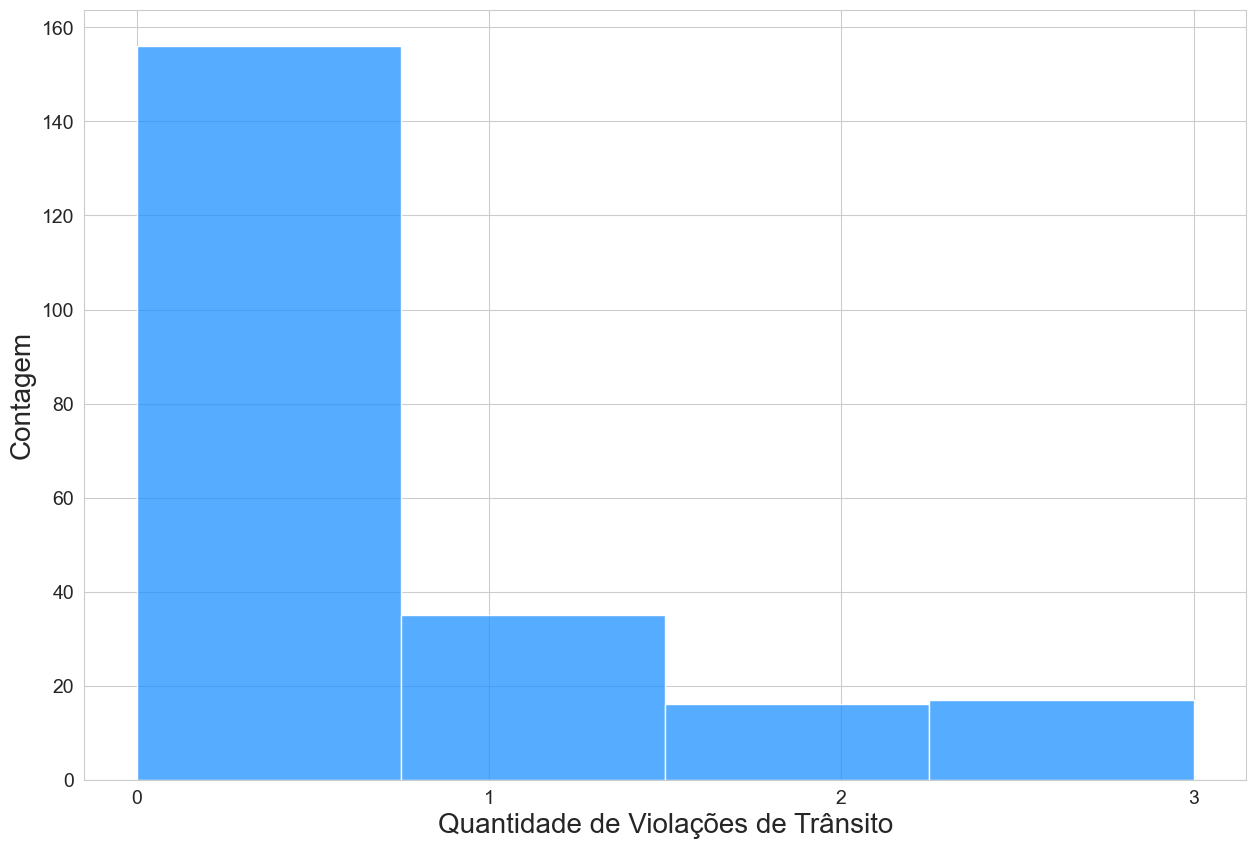

In [4]:
# Histograma da variável dependente 'violations' no dataframe 'df_corruption2'

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(15,10))
    sns.histplot(data=df_corruption2, x='violations', bins=4,
                 color='dodgerblue', edgecolor='white', kde=False)
    plt.xlabel('Quantidade de Violações de Trânsito', fontsize=20)
    plt.ylabel('Contagem', fontsize=20)
    plt.xticks(range(4), fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [5]:
# Diagnóstico preliminar para observação de eventual igualdade entre
# a média e a variância da variável dependente 'violations' no dataframe
# 'df_corruption2'

pd.DataFrame({'Média':[df_corruption2['violations'].mean()],
              'Variância':[df_corruption2['violations'].var()]})

,Média,Variância
0,0.526786,0.851297


In [6]:
# Estimação do 'modelo_poisson2'

modelo_poisson2 = smf.glm(formula='violations ~ staff + post + corruption',
                          data=df_corruption2,
                          family=sm.families.Poisson()).fit()

# Parâmetros do 'modelo_poisson2'
print(modelo_poisson2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             violations   No. Observations:                  224
Model:                            GLM   Df Residuals:                      220
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -179.47
Date:                Tue, 10 Sep 2024   Deviance:                       196.25
Time:                        20:14:03   Pearson chi2:                     243.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3919
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1322      0.145      0.909      

In [8]:
# Teste de superdispersão no dataset 'corruption2'

# Função 'overdisp'
# Instalação e carregamento da função 'overdisp' do pacote 'statstests.tests'
# Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos
# https://stats-tests.github.io/statstests/

from statstests.tests import overdisp

# Elaboração direta do teste de superdispersão
print(overdisp(modelo_poisson2, df_corruption2))

Estimating model...: 
 GLM
                       Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): -0.004  
Dependent Variable:     ystar            AIC:                         899.5607
Date:                   2024-09-10 20:15 BIC:                         902.9724
No. Observations:       224              Log-Likelihood:              -448.78 
Df Model:               1                F-statistic:                 0.1004  
Df Residuals:           223              Prob (F-statistic):          0.752   
R-squared (uncentered): 0.000            Scale:                       3.2335  
-----------------------------------------------------------------------------------
              Coef.       Std.Err.        t         P>|t|        [0.025      0.975]
-----------------------------------------------------------------------------------
lmbda         0.0500        0.1577      0.3169      0.7516      -0.2607      0.3607
-----------------------------

In [9]:
# Estimação do modelo binomial negativo ('modelo_bneg2') no dataframe
# 'df_corruption2'

from tqdm import tqdm # para mostrar o progresso do loop

n_samples = 1000
alphas = np.linspace(0, 10, n_samples)
llf = np.full(n_samples, fill_value=np.nan)

for i, alpha in tqdm(enumerate(alphas), total=n_samples, desc='Estimating'):
    try:
        model = smf.glm(formula='violations ~ staff + post + corruption',
                        data=df_corruption2,
                        family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    except:
        continue
    llf[i] = model.llf

fi_ótimo2 = alphas[np.nanargmax(llf)].round(4)
fi_ótimo2

Estimating: 100%|██████████| 1000/1000 [00:09<00:00, 100.61it/s]


np.float64(0.0901)

In [10]:
# Estimação propriamente dita do 'modelo_bneg2'

modelo_bneg2 = smf.glm(formula='violations ~ staff + post + corruption',
                      data=df_corruption2,
                      family=sm.families.NegativeBinomial(alpha=fi_ótimo2)).fit()

# Parâmetros do 'modelo_bneg2'
print(modelo_bneg2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             violations   No. Observations:                  224
Model:                            GLM   Df Residuals:                      220
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -179.33
Date:                Tue, 10 Sep 2024   Deviance:                       186.10
Time:                        20:16:52   Pearson chi2:                     232.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3767
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1243      0.151      0.824      

In [11]:
# Comparando os parâmetros e os valores de LogLiks dos 'modelo_poisson2'
# e 'modelo_bneg2'

summary_col([modelo_poisson2, modelo_bneg2], 
            model_names=["Poisson","BNeg"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
                })

,Poisson,BNeg
Intercept,0.1322,0.1243
,(0.1453),(0.1510)
post[T.yes],-2.0552***,-2.0603***
,(0.2256),(0.2306)
staff,0.0100,0.0109
,(0.0100),(0.0102)
corruption,0.3562***,0.3619***
,(0.1048),(0.1085)
Log-lik,-179.47,-179.33
N,224,224


In [12]:
# Definição da função para realização do teste de razão de verossimilhança

# Definição da função 'lrtest' (já definida anteriormente neste código)

def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade
    
    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

In [14]:
# Teste de de razão de verossimilhança para comparar as estimações dos
# 'modelo_poisson2' e 'modelo_bneg2'

lrtest([modelo_poisson2, modelo_bneg2])

Likelihood Ratio Test:
-2.(LL0-LLm): 0.28
p-value: 0.596

==================Result======================== 

H0: Models with log-likelihoods that are not statistically different at 95% confidence level


**Quando não há superdispersão, não existem diferenças significantes entre os modelos Poisson e binomial negativo!**